In [1]:
import os
import cv2
import easyocr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
# -----------------------------------------------------
# SETTINGS
# -----------------------------------------------------
IMAGE_FOLDER = "images"
OUTPUT_FOLDER = "output"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print("Loading OCR model...")
reader = easyocr.Reader(['en'], gpu=False)
print("OCR Loaded Successfully!")

Using CPU. Note: This module is much faster with a GPU.


Loading OCR model...
OCR Loaded Successfully!


### Indian State  Rules

In [3]:
import re

INDIAN_STATE_CODES = {
    "MH","KA","TN","DL","AP","TS","KL","GJ","RJ",
    "UP","MP","PB","HR","WB","OD","BR","CG","GA"
}

def normalize_plate_text(text):
    text = re.sub(r'[^A-Z0-9]', '', text)

    if len(text) < 6:
        return ""

    detected_state = text[:2]

    state_fixes = {
        "HH": "MH",
        "IH": "MH",
        "MN": "MH",
        "NH": "MH",
        "SK": "KA",
        "SO": "KA"
    }

    if detected_state not in INDIAN_STATE_CODES:
        detected_state = state_fixes.get(detected_state, detected_state)

    return detected_state + text[2:]


In [4]:
def detect_plate(image_path):

    image = cv2.imread(image_path)
    if image is None:
        return None, "Image not found"

    annotated = image.copy()
    H, W = image.shape[:2]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    binary = cv2.adaptiveThreshold(
        gray,255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,11,2
    )

    contours,_ = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)[:20]

    plate_cnt = None

    for c in contours:
        peri = cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,0.02*peri,True)

        if len(approx)==4:
            x,y,w,h = cv2.boundingRect(approx)

            if w < 80 or h < 25:
                continue

            aspect_ratio = w / h
            if aspect_ratio < 2 or aspect_ratio > 6:
                continue

            plate_cnt = approx
            break

    final_text = "Not Detected"

    if plate_cnt is not None:
        x,y,w,h = cv2.boundingRect(plate_cnt)

        x = max(0, x)
        y = max(0, y)
        w = min(w, W-x)
        h = min(h, H-y)

        plate_crop = image[y:y+h, x:x+w]

        if plate_crop.size == 0:
            return annotated, "Crop Failed"

        results = reader.readtext(
            plate_crop,
            allowlist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        )

        cv2.rectangle(annotated,(x,y),(x+w,y+h),(0,255,0),3)

        for (box,text,conf) in results:
            final_text = normalize_plate_text(text)

            tl,_,br,_ = box
            tl=(int(tl[0]+x),int(tl[1]+y))
            br=(int(br[0]+x),int(br[1]+y))
            cv2.rectangle(annotated,tl,br,(255,0,0),2)

        cv2.putText(annotated,final_text,(x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)

    return annotated, final_text


### Code for PlATE Detection

C:\Users\samma\anaconda3\envs\GopiMllab\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


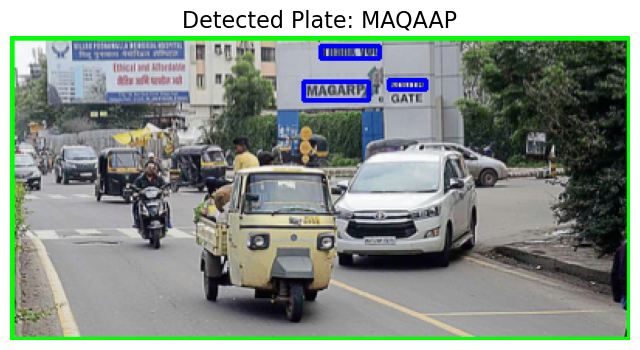

Image: Cars103.png
Detected Plate: MAQAAP
--------------


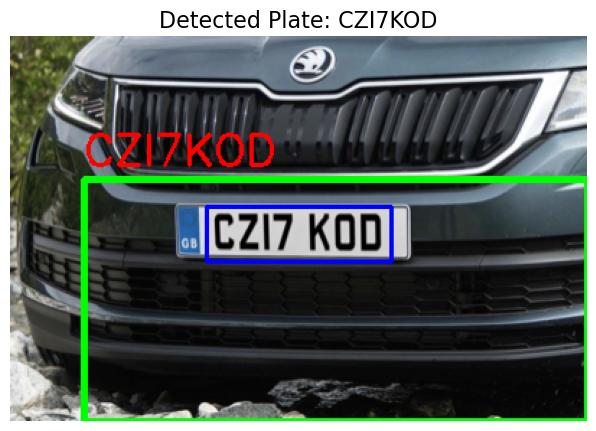

Image: Cars109.png
Detected Plate: CZI7KOD
--------------


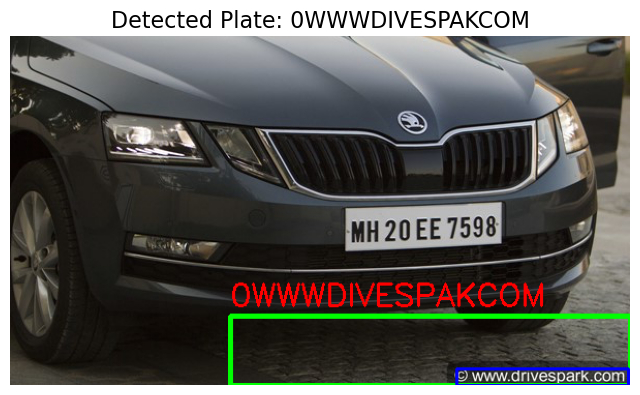

Image: Cars111.png
Detected Plate: 0WWWDIVESPAKCOM
--------------


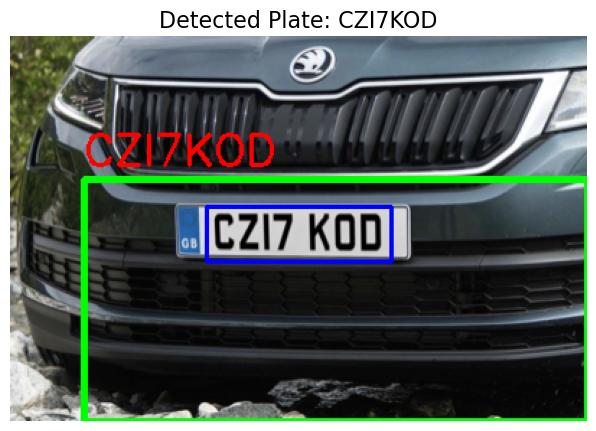

Image: Cars203.png
Detected Plate: CZI7KOD
--------------


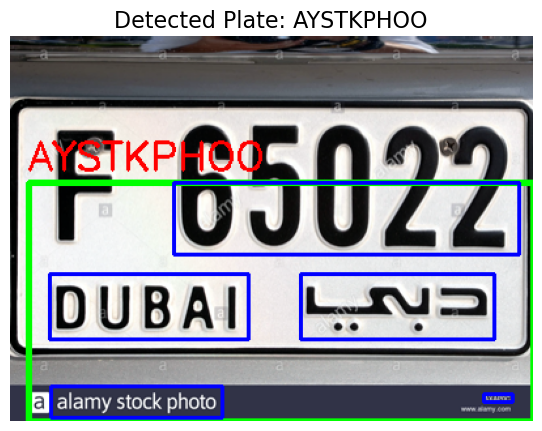

Image: Cars211.png
Detected Plate: AYSTKPHOO
--------------


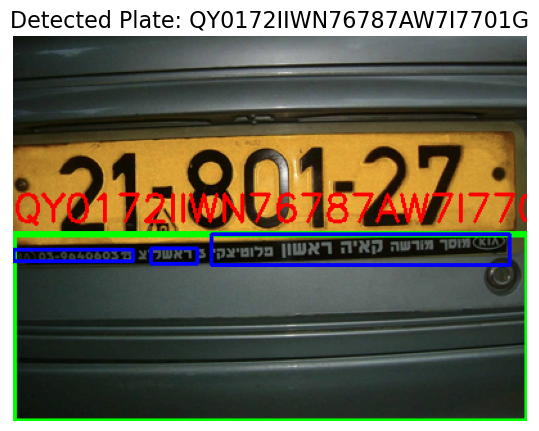

Image: Cars244.png
Detected Plate: QY0172IIWN76787AW7I7701G
--------------


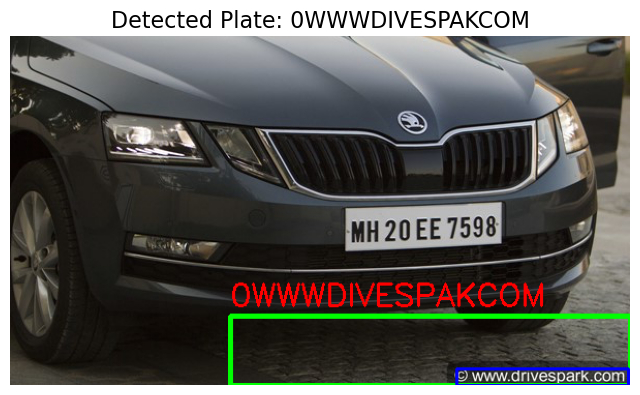

Image: Cars259.png
Detected Plate: 0WWWDIVESPAKCOM
--------------


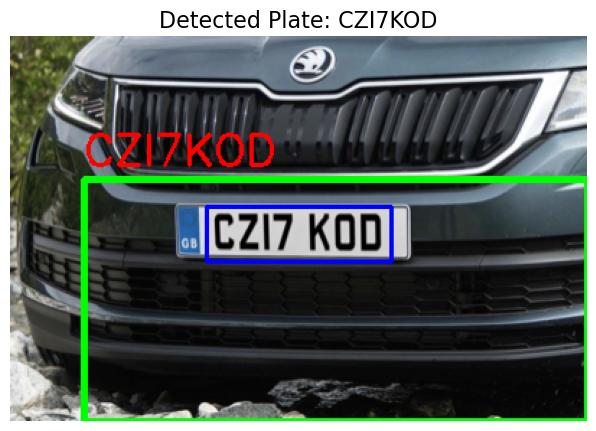

Image: Cars276.png
Detected Plate: CZI7KOD
--------------


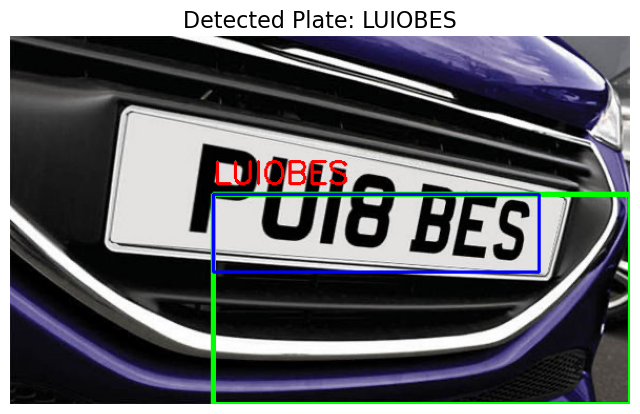

Image: Cars312.png
Detected Plate: LUIOBES
--------------


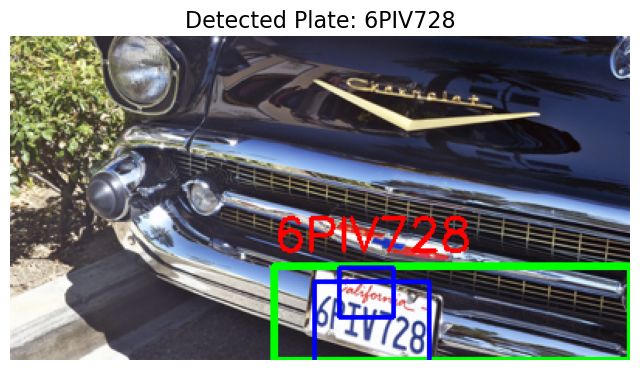

Image: Cars314.png
Detected Plate: 6PIV728
--------------


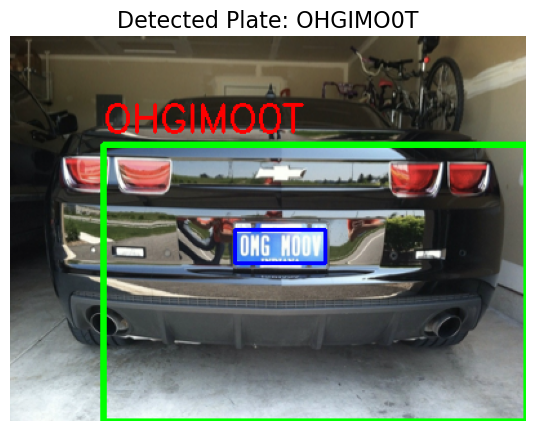

Image: Cars345.png
Detected Plate: OHGIMO0T
--------------


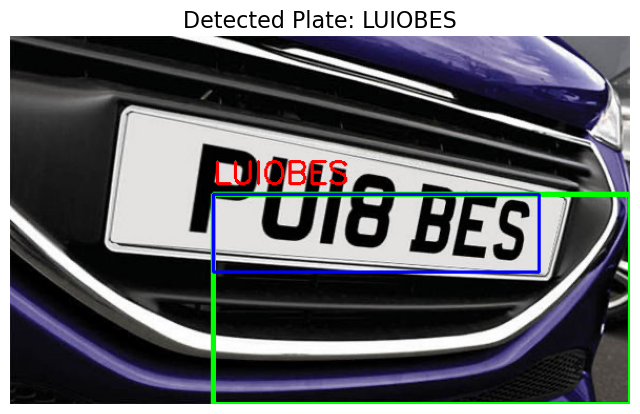

Image: Cars4.png
Detected Plate: LUIOBES
--------------


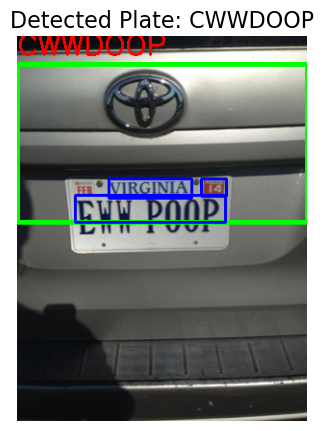

Image: Cars410.png
Detected Plate: CWWDOOP
--------------


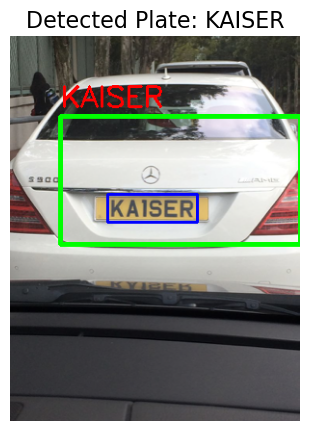

Image: Cars429.png
Detected Plate: KAISER
--------------


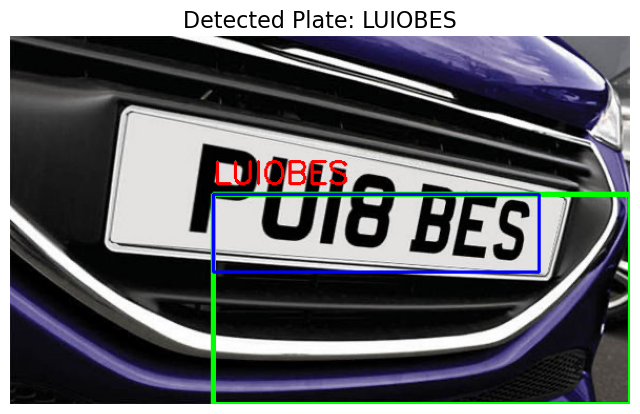

Image: Cars50.png
Detected Plate: LUIOBES
--------------


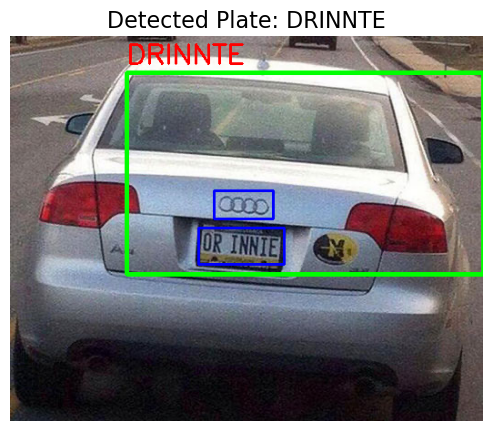

Image: Cars65.png
Detected Plate: DRINNTE
--------------


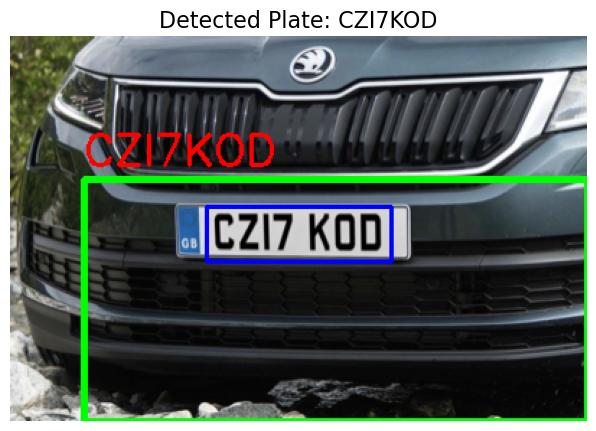

Image: Cars74.png
Detected Plate: CZI7KOD
--------------


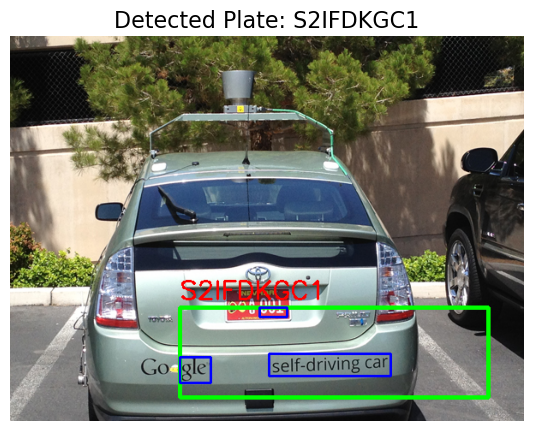

Image: Cars83.png
Detected Plate: S2IFDKGC1
--------------

Total Successful Detections: 18

All images processed!
Results saved in plate_results.csv
Annotated images saved in /output folder


In [5]:
results_list = []

image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".png")]

success_count = 0

for img_name in image_files:
    path = os.path.join(IMAGE_FOLDER, img_name)
    result_img, plate = detect_plate(path)

    results_list.append([img_name, plate])

    if plate not in ["Not Detected", "Crop Failed", "", None]:

        success_count += 1

        save_path = os.path.join(OUTPUT_FOLDER, img_name)
        cv2.imwrite(save_path, result_img)

        plt.figure(figsize=(8,5))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Plate: {plate}", fontsize=16)
        plt.axis("off")
        plt.show()

        print("Image:", img_name)
        print("Detected Plate:", plate)
        print("--------------")

print("\nTotal Successful Detections:", success_count)


df = pd.DataFrame(results_list, columns=["Image", "Detected Plate"])
df.to_csv("plate_results.csv", index=False)

print("\nAll images processed!")
print("Results saved in plate_results.csv")
print("Annotated images saved in /output folder")
